***

<a id='beginning'></a> <!--\label{beginning}-->
* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [4. The Visibility space](4_0_introduction.ipynb)
    * Previous: [4.5.1 UV Coverage: UV tracks](4_5_1_uv_coverage_uv_tracks.ipynb)
    * Next: [4.6 The Fourier Approximation & the van Cittert-Zernike theorem](4_6_the_fourier_approximation_van_cittert-zernike_theorem.ipynb)

***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [2]:
from IPython.display import display
from ipywidgets import *
from mpl_toolkits.mplot3d import Axes3D
import plotBL

In [3]:
HTML('../style/code_toggle.html')

HTML(value='../style/code_toggle.html')

***

### 4.5.2 $uv$ coverage : Improving your $uv$ coverage

In [$\S$ 4.5.1 &#10142;](4_5_1_uv_coverage_uv_tracks.ipynb), we have explored the ways in which the visibility function is sampled. Depending on the interferometer's location (in latitude), the projected baseline w.r.t. the observed source, and the time and frequency of our observation, the $uv$ plane is sampled along tracks which can be derived from the projected baseline in the ($u$,$v$,$w$) reference frame. These $uv$ tracks are portions of ellipses. Over the course of an observation, samples are accumulated along these tracks and form the *$uv$ coverage*.
To accurately measure the sky, we need a good knowledge of its attendant visibility function: we therefore need to sample the $uv$-plane as fully as possible.

<span style="background-color:cyan">TLG:GM: Check if the italic words are in the glossary. </span>

We will see, in this section, how the $uv$ coverage can be improved using multiple element interferometers ([$\S$ 4.5.2.1 &#10549;](#vis:sec:4521))  and using time ([$\S$ 4.5.2.2 &#10549;](#vis:sec:4522)) and frequency ([$\S$ 4.5.2.3 &#10549;](#vis:sec:4523)) integration to our advantage.

<a id="vis:sec:4521"></a> 
#### 4.5.2.1 Configuration of an $N$-element interferometer

Until now, we only considered 2-element interferometers. In practice, interferometers are built from $N>2$  elements. We then compute the corresponding $\frac{N(N-1)}{2}$ independent cross-correlations (doing this for each frequency channel, each time step and each polarization). For an $N$-element interferometer, the sampling in the $uv$ plane is thus proportional to $\sim N^2$.

In the following, we will show the characteristic $uv$ coverage of existing, well-known radio interferometers, observing at a single frequency and for a single time step (i.e. a *snapshot* observation). You may select the array of your choice from the list below:

In [4]:
config = widgets.Dropdown(
    options={'VLAa':'configs/vlaa.enu.txt',
        'VLAb':'configs/vlab.enu.txt',
        'VLAc':'configs/vlac.enu.txt',
        'VLAd':'configs/vlad.enu.txt',
        'WSRT':'configs/wsrt.enu.txt',
        'kat7':'configs/kat-7.enu.txt',
        'meerkat':'configs/meerkat.enu.txt'},
    value="configs/vlaa.enu.txt",
    Description="Antennas:")

display(config)

Dropdown(options={'VLAa': 'configs/vlaa.enu.txt', 'VLAb': 'configs/vlab.enu.txt', 'VLAc': 'configs/vlac.enu.tx…

From the list above, you can select different configurations corresponding to real instrumental layouts.
However, if you want to specify the relative positions of the antennas in an $ENU$ reference frame yourself, you can edit the following block and set the variable "custom" to "1".

In [5]:
# you need to re-evaluate this box if you modify the array.
antennaPosition=np.genfromtxt(config.value)


In [6]:
# custom antenna distribution
custom=0
if (custom):
    antennaPosition = np.zeros((10, 2), dtype=float)
    antennaPosition[0,:] = [0,0]
    antennaPosition[1,:] = [-4, 5]
    antennaPosition[2,:] = [4, 5]
    antennaPosition[3,:] = [-10,0]
    antennaPosition[4,:] = [-8,-3]
    antennaPosition[5,:] = [-4,-5]
    antennaPosition[6,:] = [0,-6]
    antennaPosition[7,:] = [4,-5]
    antennaPosition[8,:] = [8,-3]
    antennaPosition[9,:] = [10,0]

Let's plot the distribution of the antennas from the selected (or customized) interferometer:

/feynman/home/dap/lcs/ec270266/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'Antenna positions')

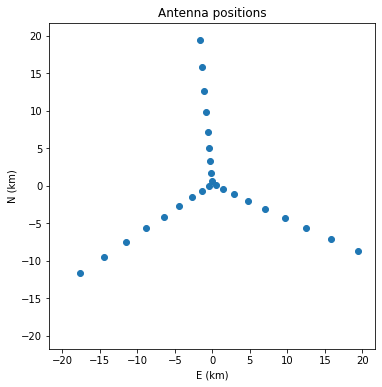

In [7]:
%matplotlib inline
mxabs = np.max(abs(antennaPosition[:]))*1.1
# make use of pylab librery to plot
fig=plt.figure(figsize=(6,6))
plt.plot((antennaPosition[:,0]-np.mean(antennaPosition[:,0]))/1e3, \
         (antennaPosition[:,1]-np.mean(antennaPosition[:,1]))/1e3, 'o')
plt.axes().set_aspect('equal')
plt.xlim(-mxabs/1e3, mxabs/1e3)
plt.ylim(-mxabs/1e3, (mxabs+5)/1e3)
plt.xlabel("E (km)")
plt.ylabel("N (km)")
plt.title("Antenna positions")

<a id="fig:4414"></a>
**Figure 4.5.14**: Distribution of the antennas in a $ENU$ reference frame. Each dot represents an antenna which will be part of $N$-1 baselines.

As for the previous simulations, we will simulate an observation using the VLA as the default case.

##### 4.5.2.1.1 Observation configuration

In [14]:
# Observation parameters
c=3e8                                         # Speed of light
f=1420e6                                      # Frequency
lam = c/f                                     # Wavelength 

time_steps = 1200                              # time steps
h = np.linspace(-6,6,num=time_steps)*np.pi/12 # Hour angle window

# declination convert in radian

L = np.radians(34.0790)      # Latitude of the VLA
dec = np.radians(34.)

#### 4.5.2.1.2 The *snapshot* $\boldsymbol{uv}$ coverage

In [15]:
antennaPosition

array([[ 0.00000000e+00,  0.00000000e+00],
       [-9.30632921e+02, -6.27921957e+02],
       [-2.27554312e+03, -1.53555358e+03],
       [-3.98747225e+03, -2.69146310e+03],
       [-6.03692270e+03, -4.07596409e+03],
       [-8.40257726e+03, -5.67520955e+03],
       [-1.10680556e+04, -7.47807220e+03],
       [-1.40201416e+04, -9.47674517e+03],
       [-1.72475339e+04, -1.16636667e+04],
       [ 8.52822235e+02,  6.71465269e+01],
       [ 1.87037978e+03, -4.07448833e+02],
       [ 3.34070468e+03, -1.09344373e+03],
       [ 5.21240009e+03, -1.96719943e+03],
       [ 7.45334999e+03, -3.01399283e+03],
       [ 1.00401573e+04, -4.22308622e+03],
       [ 1.29551629e+04, -5.58671997e+03],
       [ 1.61838077e+04, -7.09846502e+03],
       [ 1.97721927e+04, -8.62699361e+03],
       [ 3.68796045e+02,  7.16135664e+02],
       [ 2.80507314e+02,  1.72475572e+03],
       [ 1.43994716e+02,  3.28341729e+03],
       [-9.73716477e+00,  5.03797528e+03],
       [-2.04543919e+02,  7.26005778e+03],
       [-4.

<Figure size 432x288 with 0 Axes>

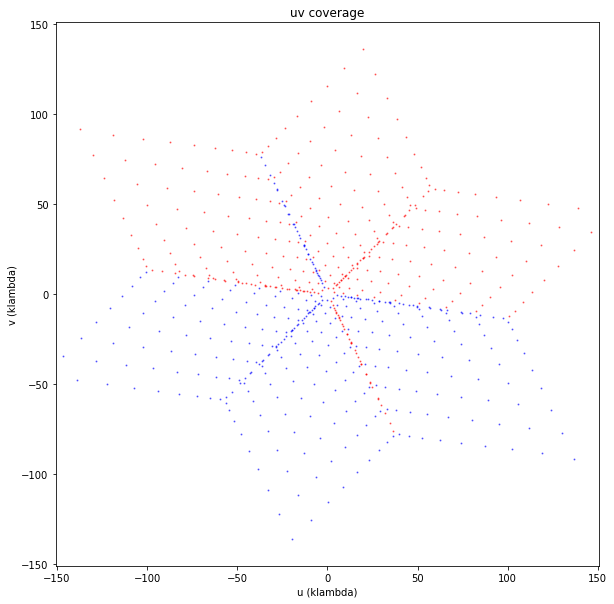

In [16]:
# %matplotlib inline
Ntimes=1
plotBL.plotuv(antennaPosition,L,dec,h,Ntimes,lam)

<a id="vis:fig:4515"></a> 
**Figure 4.5.15**: Snapshot $uv$ coverage of the interferometer. Red and blue points correspond to symmetric $uv$ points: indeed, each baseline gives us the measurement of $V_\nu$ at ($u$,$v$) __and__ its complex conjugate $V^*_\nu$ at ($-u$,$-v$).

Depending on the number of elements and their relative distribution on the ground, the shape of the snapshot $uv$ coverage can vary dramatically from one interferometer to another. One may prefer an antenna distribution which maximizes an instantaneous coverage which spans the entire $uv$ plane (e.g. VLA in [Fig. 4.5.15 &#10549;](#vis:fig:4515)) rather than a compact array which samples a smaller portion of the $uv$ plane. With the raw increase of total sensitivity, improving the instantaneous $uv$ coverage is the main motivation for increasing the number of antennas and optimising their relative positions. A *good* $uv$ coverage is obtained if the $uv$ plane is sufficiently - and smoothly! - sampled. In the next section, we will see how the Earth contributes to improve the $uv$ coverage.

<a id="vis:sec:4522"></a> 
#### 4.5.2.3 Time integration: Earth Rotation Synthesis

Observing a source for several hours requires tracking this source with fringe (or delay) tracking. As the source moves with the sky, the projected baselines - as seen from the source - will continuously vary along elliptical $uv$ tracks.
With good enough time sampling, it is possible to sample each $uv$ track along the observation and accumulate a number of $\frac{N(N-1)}{2}\times N_\text{times}$ independent measurements.

The following experiment will allow you to change the number of time steps collected during an observation, from a snapshot observation up to a 12 hour observation.

The next block will let you plot a snapshot observation. You can increase the duration of the observation with the slider which defines the total number of time steps for which the $uv$ coverage is computed. When using the slider, the new resulting plot will be generated next to the previous one to allow for visual comparisons.

(Test values of 2, $\sim$300, $\sim$1200 to see the effects on the $uv$ coverage. Give the notebook some time to regenerate the plot, especially for large values of time samples!).

/feynman/home/dap/lcs/ec270266/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  # Remove the CWD from sys.path while we load stuff.


IntSlider(value=2, continuous_update=False, description='Ntimes', max=1200, min=2, step=100)

Ntimes=2


<Figure size 432x288 with 0 Axes>

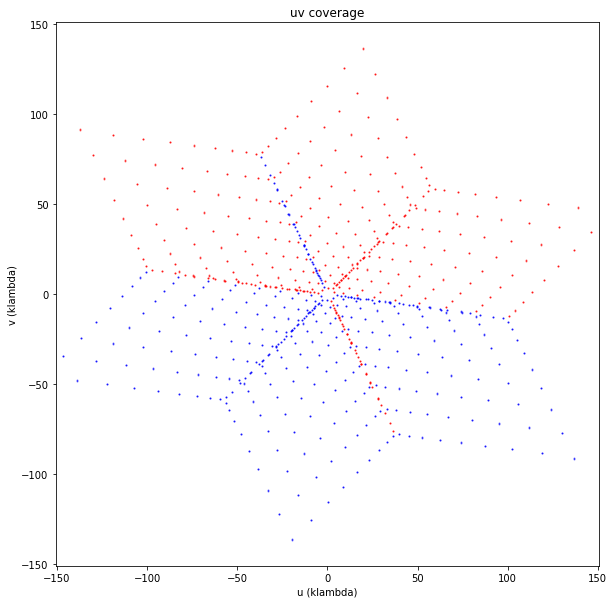

Ntimes=1102


<Figure size 432x288 with 0 Axes>

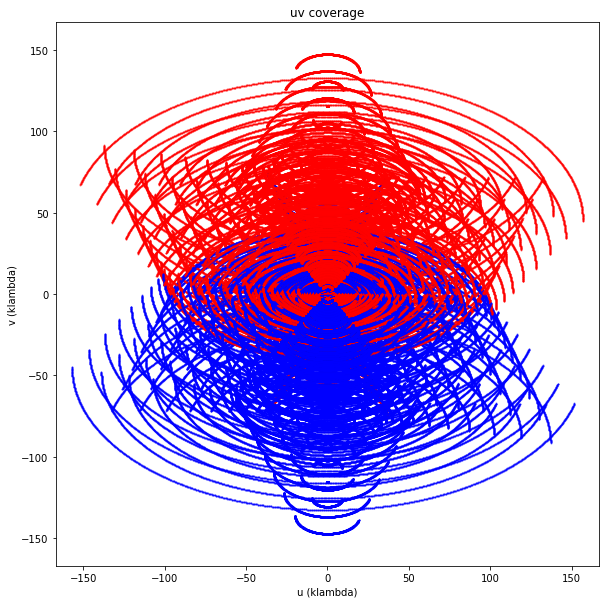

In [17]:
from ipywidgets import *
from IPython.display import display

def Interactplot(key,Ntimes):
    print("Ntimes="+str(Ntimes))
    plotBL.plotuv(antennaPosition,L,dec,h,Ntimes,lam)
    
slider=IntSlider(description="Ntimes",min=2,max=1200,step=100,continuous_update=False)

slider.on_trait_change(Interactplot,'value')
display(slider)
Interactplot("",2)

<a id="fig:4416"></a>
**Figure 4.5.16**: Sampled $uv$ coverage of the interferometer for various values of time samples. Red and blue points corresponds to symmetric $uv$ points, since each baseline give us the measurement of $V_\nu$ at ($u$,$v$) **and** its complex conjugate $V^*_\nu$ at ($-u$,$-v$).

With an increasing number of time steps, you can start to see each individual baselines' elliptical $uv$ track in the $uv$ plane. It is easy to see that the longer the observation, the better our sampling of the visibility function.

<a id="vis:sec:4523"></a> 
#### 4.5.2.3 Integration in frequency: Frequency Synthesis

We have seen in [$\S$ 4.3 &#10142;](4_2_The_2-element_Interferometer.ipynb) that the $u$, $v$, $w$ coordinates are usually normalized by $\lambda$. As a consequence, observing with the *same* interferometer at a *different* frequency gives a different set of spatial frequencies. Sampling the ($u,v$)-plane with the same baseline and two diffe frequencies is equivalent to **rescaling** the projected baseline. Indeed, for the same snapshot $uv$ coverage at wavelength $\lambda_1$, the $uv$ coverage at $\lambda_2 < \lambda_1$ will be a shrunk version of that a $\lambda_1$. 

If the distribution of our sampling frequencies is (quasi) continuous, e.g. if the observing system operates in a bandwidth [$f_\text{min}$,$f_\text{max}$], with $N_\text{freqs}$ channels, we can contiguously sample portions of the $uv$ plane with $\frac{N(N-1)}{2}\times N_\text{freqs}$ independent measurements. For each baseline, a radial track will be generated due to the frequency scaling effect of $u$ and $v$.

<div class=warn>
<b>Warning:</b> It is only possible to do this up to a point: see *bandwidth smearing* in [$\S$ 9.3 &#10142;](../9_Practical/9_3_observing_smearing.ipynb)) for more details on the limits of this technique.
</div>
<span style="background-color:cyan">TLG:GM: Check if the italic words are in the glossary. </span>

In the next block, we will plot a snapshot observation. You can increase the number of continuous frequency channels  (at 10 MHz steps) with the slider. Upon a change on the slider, a new plot will be generated next to the previous one, to allow visual comparisons (Note: give the notebook some time to generate the plot).

(Test values of 1, 20, 200 to see the effects on the $uv$ coverage).

/feynman/home/dap/lcs/ec270266/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  if sys.path[0] == '':


IntSlider(value=1, continuous_update=False, description='Nfreqs', max=200, min=1)

Nfreqs=1


/feynman/work/dap/lcs/ec270266/argos/fundamentals_of_interferometry/4_Visibility_Space/plotBL.py:211: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


<Figure size 432x288 with 0 Axes>

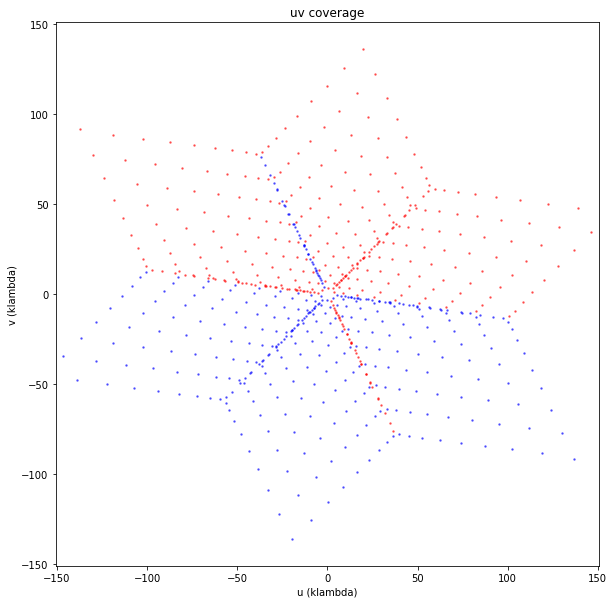

Nfreqs=14


/feynman/work/dap/lcs/ec270266/argos/fundamentals_of_interferometry/4_Visibility_Space/plotBL.py:211: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


<Figure size 432x288 with 0 Axes>

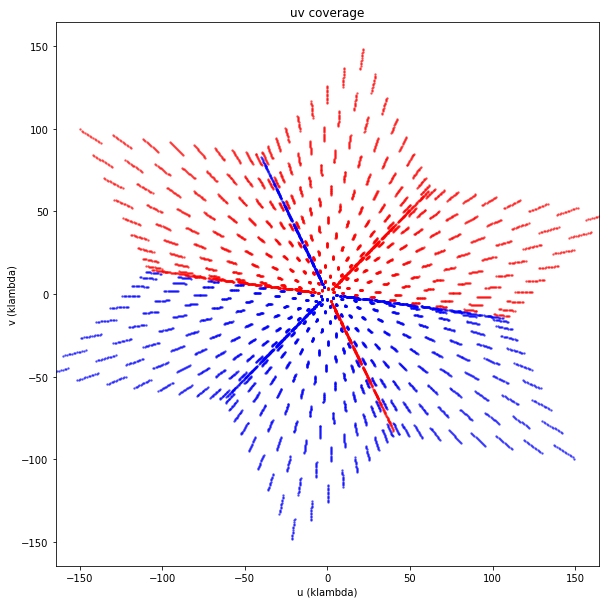

In [13]:
df=10e6 # frequency step
f0=c/lam # starting frequency
lamb0=lam # starting wavelength


def Interactplot(key,Nfreqs):
    print("Nfreqs="+str(Nfreqs))
    plotBL.plotuv_freq(antennaPosition,L,dec,h,Nfreqs,lamb0,df)
    
slider=IntSlider(description="Nfreqs",min=1,max=200,step=1,continuous_update=False)

slider.on_trait_change(Interactplot,'value')
display(slider)
Interactplot("",1)

<a id="fig:4417"></a>
**Figure 4.5.17**: Snapshot $uv$ coverage of the interferometer for various numbers of frequency channels. Red and blue points corresponds to symmetric $uv$ points, since each baseline give us the measurement of $V_\nu$ at ($u$,$v$) **and** its complex conjugate $V^*_\nu$ at ($-u$,$-v$).

With an increasing number of frequency channels, you can see each individual baseline following a radial track on the $uv$-plane. It is easy to see that the more frequency channels you allocate to an observation, the better the sampling of the visibility function (theoretically at least!).

#### 4.5.2.4 Conclusion

The $uv$ plane is what an interferometers actually measures.

In an ideal case, this plane is equivalent to the visibility function, which what we **want** to measure. The $uv$-coverage of an observation tells us which parts of the visibility function has been sampled.

In [$\S$ 4.5.1 &#10142;](4_5_1_uv_coverage_uv_tracks.ipynb), we showed that sampling the $uv$-plane with a single baseline amounts to sampling along an elliptical track due to the rotation of the Earth. The track's parameters can be predicted if we know the location of the interferometer on Earth, the direction of the source and the baseline characteristics. The $uv$-track is thus the set of spatial frequencies (i.e.$uv$ points) which a single baseline will sample over the course of an observation.

In [$\S$ 4.5.2 &#10549;](4_5_2_uv_coverage_improving_your_coverage.ipynb), we discussed three different ways of improving your $uv$ coverage. Firstly, we can increase the number of antennas and alter their distribution: this improves the *instantaneous* spatial coverage. Second, we can use the fact that the observed source is moving with the Celestial Sphere (i.e. the Earth spins). The continuous variation of the projected baseline - and therefore its $u,v$-coordinates - allow us to sample portions of elliptical $uv$ tracks. 

A long integration time allows astronomers to easily improve their $uv$-plane coverage at little cost. Note that maximising using this technique to improve $uv$-coverage will require taking more measurements in time, thus increasing computational costs.

Thirdly, by using broadband receivers, we can sample the visibilities at various frequencies and compute the cross-correlations in different frequency channels. By doing so, the $uv$-coverage is improved along radial $uv$ tracks.
Of course, these methods cannot extend our $uv$-coverage arbitrarily. They are limited by both the instrument sensitivity and the instrument's point source response (see [$\S$ 9.3 &#10142;](../9_Practical/9_3_Observing_smearing.ipynb)).

In [$\S$ 4.6  &#10142;](4_6_the_fourier_approximation_van_cittert-zernike_theorem.ipynb) we will explicitly enunciate the underlying hypotheses we relied on in the previous section. This section is required before we can begin to treat the topic of *imaging* in [$\S$ 5 &#10142;](../5_Imaging/5_0_introduction.ipynb).

<p class=conclusion>
<font size=4><b>Important things to remember</b></font>
<br>
<br>
&bull; The number of antennas and their non-redundant distribution are important factors to improve the *snapshot* $uv$ coverage.<br>
&bull; Time integration using Earth Rotation Synthesis (a technique known in the literature as *supersynthesis*) builds up the elliptical $uv$ tracks of each baseline, but generates <em>time smearing</em>.<br>
&bull; Frequency integration - observing in a larger bandwidth composed of multiple contiguous channels - also helps improve the $uv$ coverage radially, but generates <em>frequency smearing</em>.<br>
</p>

#### Format status:

* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : LF: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : NC: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : RF: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : HF: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : GM: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : CC: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : CL: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : ST: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : FN: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : TC: 09/02/2017
* <span style="background-color:green">&nbsp;&nbsp;&nbsp;&nbsp;</span> : XX: 09/02/2017

***

* Next: [4.6 The Fourier Approximation & the van Cittert-Zernike theorem](4_6_the_fourier_approximation_van_cittert-zernike_theorem.ipynb)